# Whisker deep nets related

Script to watch the status of neural networks trained

## Important imports

In [1]:
import pymongo as pm
#conn = pm.MongoClient(port=27016)
conn = pm.MongoClient(port=29100)
conn_2 = pm.MongoClient(port=29101)

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

from scipy import misc
import os
import time
import gridfs
import cPickle

In [72]:
def show_train_learnrate(curr_expid, conn = conn, dbname = 'whisker_net', colname = 'catenet.files', start_N = 50, 
                        do_conv = False, conv_len = 100, new_figure = True, 
                         do_combine=False, no_learningrate = False, drop_epoch = None):
    train_vec = np.concatenate([[(_r['loss'], _r['learning_rate']) for _r in r['train_results']] 
                for r in conn[dbname][colname].find(
                {'exp_id': curr_expid, 'train_results': {'$exists': True}})])
    
    train_vec = train_vec[train_vec[:, 0] < 6]
    if do_combine:
        train_vec_p = np.concatenate([[(_r['loss'], _r['learning_rate']) for _r in r['train_results']] 
                    for r in conn[dbname][colname].find(
                    {'exp_id': 'catenet_adag_flv_slac_2', 'train_results': {'$exists': True}})])
        train_vec_p = train_vec_p[train_vec_p[:, 0] < 6]
        train_vec = np.concatenate([train_vec_p[:70000], train_vec], 0)
    #print(train_vec.shape)
    _N = start_N
    if new_figure:
        if no_learningrate:
            fig = plt.figure(figsize=(10, 5))
        else:
            fig = plt.figure(figsize=(16, 5))
    if not no_learningrate:
        plt.subplot(1, 2, 1)
    inter_list = train_vec[_N:, 0]
    if do_conv:
        conv_list = np.ones([conv_len])/conv_len
        inter_list = np.convolve(inter_list, conv_list, mode='valid')
    epoch_list = np.asarray(range(len(inter_list)))*1.0/7500
    if not drop_epoch==None:
        epoch_list_flag = epoch_list < drop_epoch
        inter_list = inter_list[epoch_list_flag]
        epoch_list = epoch_list[epoch_list_flag]
    plt.plot(epoch_list, inter_list)
    plt.title('Training loss', fontsize = 20)
    plt.ylabel('Loss', fontsize = 18)
    plt.xlabel('#Epoch', fontsize = 18)
    if not no_learningrate:
        plt.subplot(1, 2, 2)
        plt.plot(train_vec[_N:, 1])
        plt.title('Learning Rate', fontsize = 20)



    #plt.gca().set_xscale('log')


In [77]:
def show_val(curr_expid, conn = conn, key = 'top1', dbname = 'whisker_net', colname = 'catenet.files', 
             new_figure = True, do_combine = False, drop_epoch = None):
    test_vec = [r['validation_results']['topn'][key] for r in conn[dbname][colname].find({'exp_id': curr_expid,
                                                                                        'validation_results': {'$exists': True}})]
    
    if do_combine:
        test_vec_p = [r['validation_results']['topn'][key] for r in conn[dbname][colname].find({'exp_id': 'catenet_adag_flv_slac_2',
                    'validation_results': {'$exists': True}})]
        test_vec = test_vec_p[:15] + test_vec
    
    _N = 0
    if new_figure:
        plt.figure(figsize=(8, 5))
    test_vec = test_vec[_N:]     
    test_vec = np.asarray(test_vec)
    epoch_list = (np.asarray(range(len(test_vec)))*5000 + 5000)*1.0/7500

    if not drop_epoch==None:
        epoch_list_flag = epoch_list < drop_epoch
        test_vec = test_vec[epoch_list_flag]
        epoch_list = epoch_list[epoch_list_flag]
        
    plt.plot(epoch_list, test_vec)
    #plt.plot(test_vec[_N:])    
    #plt.gca().set_xscale('log')
    plt.title('Validation Performance %s' % key, fontsize = 20)
    plt.ylabel('Performance', fontsize = 18)
    plt.xlabel('#Epoch', fontsize = 18)

In [5]:
def show_status(curr_expid, conn = conn_2, new_figure = True):
    show_train_learnrate(curr_expid, conn = conn_2, do_conv=True, new_figure = new_figure)
    show_val(curr_expid, conn = conn_2, key='top1', new_figure = new_figure)
    show_val(curr_expid, conn = conn_2, key='top5', new_figure = new_figure)

## Network status

In [12]:
conn['whisker_net']['catenet.files'].distinct('exp_id')

[u'catenet', u'catenet_mmt', u'catenet_adam', u'catenetsm_adam_f']

In [59]:
conn_2['whisker_net']['catenet.files'].distinct('exp_id')

[u'catenet_ff_slac',
 u'catenet_adag_ff_slac',
 u'catenet_smmmn_ff_slac',
 u'catenet_smada_ff_slac',
 u'catenet_sm_ff_slac',
 u'catenet_mmnes_ff_slac',
 u'catenet_adag_flv_slac',
 u'catenet_bn_adag_flv',
 u'catenet_bn_adam_flv']

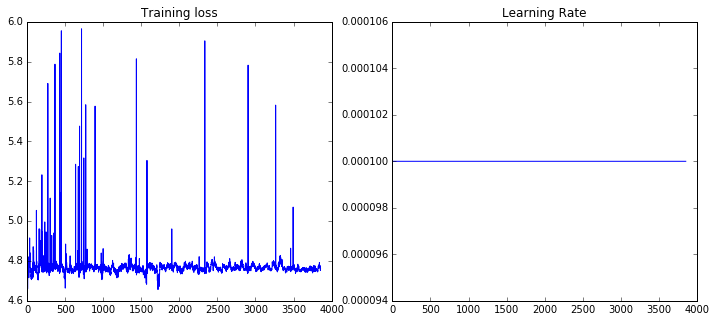

In [23]:
show_train_learnrate('catenet', start_N = 4000)

In [24]:
show_train_learnrate('catenet2')

ValueError: need at least one array to concatenate

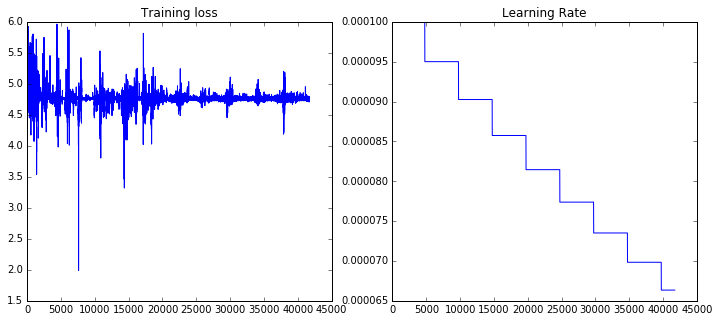

In [13]:
show_train_learnrate('catenet_adam')

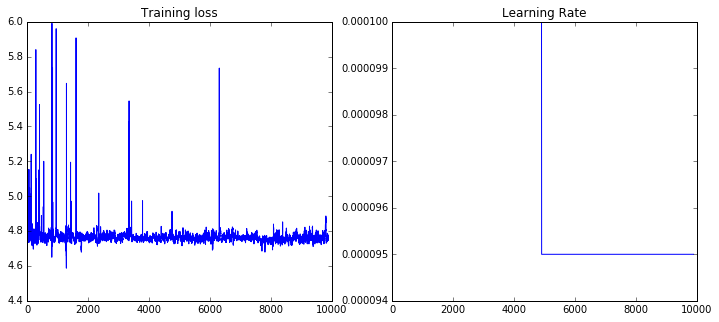

In [30]:
show_train_learnrate('catenet_mmt')

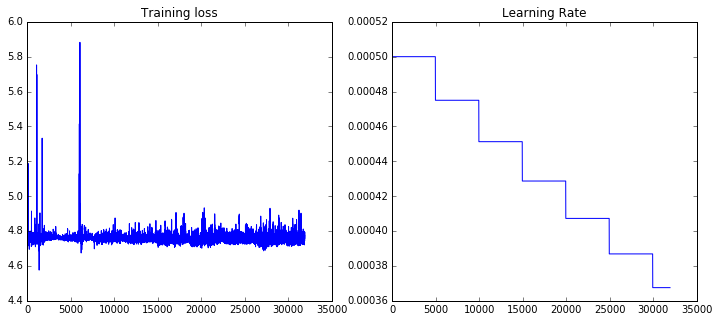

In [14]:
show_train_learnrate(u'catenetsm_adam_f')

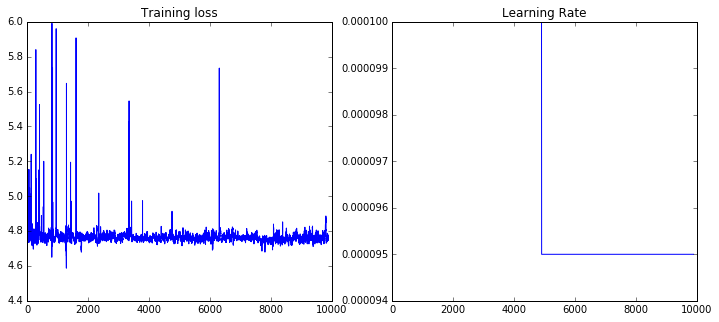

In [15]:
show_train_learnrate('catenet_mmt')

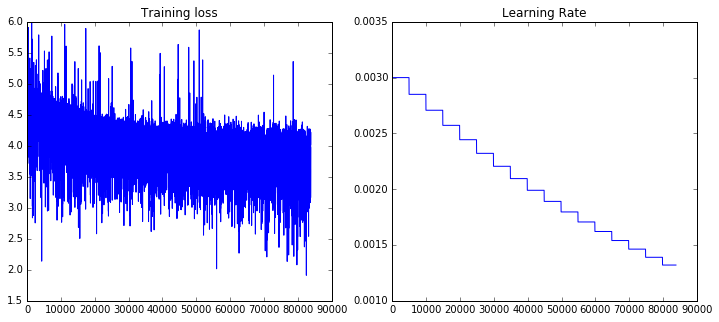

In [48]:
show_train_learnrate('catenet_adag_ff_slac', conn = conn_2)

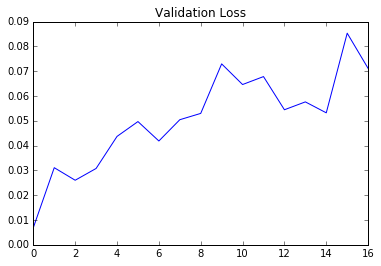

In [56]:
show_val('catenet_adag_ff_slac', conn = conn_2, key='top1')

In [35]:
12*12*9981/384

3742

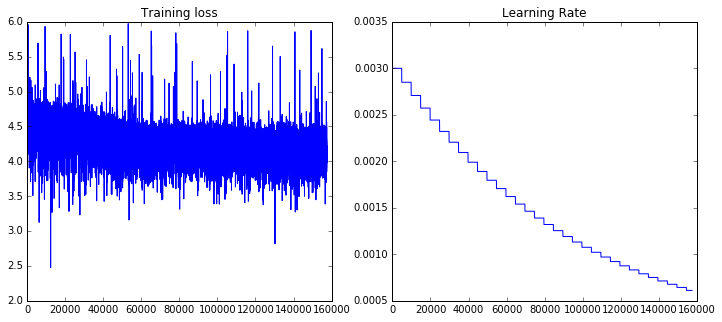

In [49]:
show_train_learnrate('catenet_smada_ff_slac', conn = conn_2)

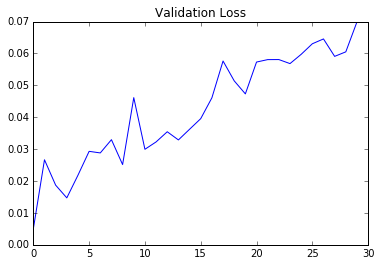

In [50]:
show_val('catenet_smada_ff_slac', conn = conn_2, key='top1')

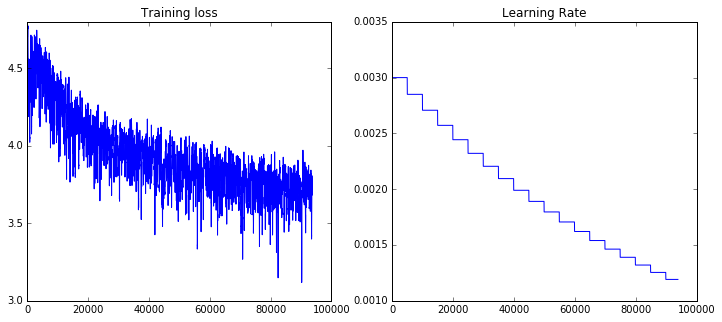

In [57]:
show_train_learnrate('catenet_adag_ff_slac', conn = conn_2, do_conv=True)

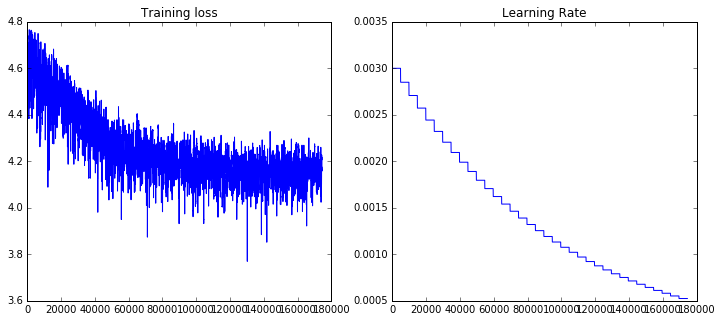

In [58]:
show_train_learnrate('catenet_smada_ff_slac', conn = conn_2, do_conv=True)

## Network using batch normalization and adagrad

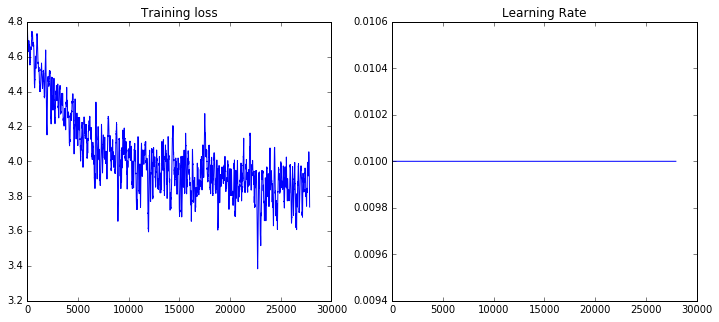

In [207]:
show_train_learnrate('catenet_bnc_adag_flv', conn = conn_2, do_conv=True)

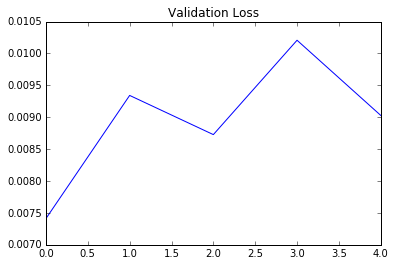

In [208]:
show_val('catenet_bnc_adag_flv', conn = conn_2, key='top1')

## Network using batch normalization and adam

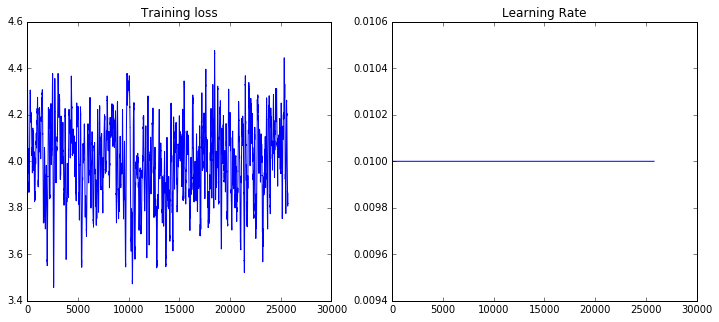

In [197]:
show_train_learnrate('catenet_bnc_adam_flv', conn = conn_2, do_conv=True)

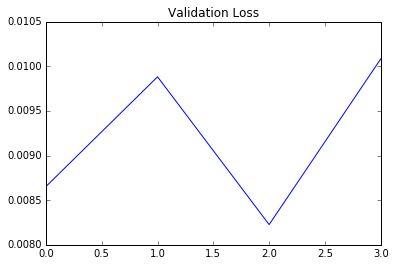

In [191]:
show_val('catenet_bnc_adam_flv', conn = conn_2, key='top1')

## Network using adagrad, no bn

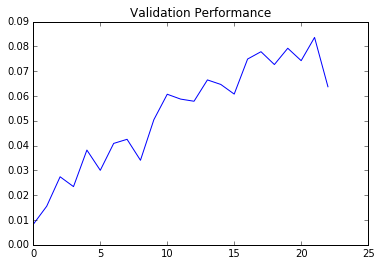

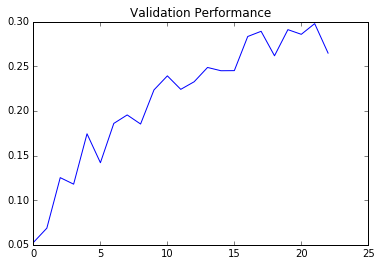

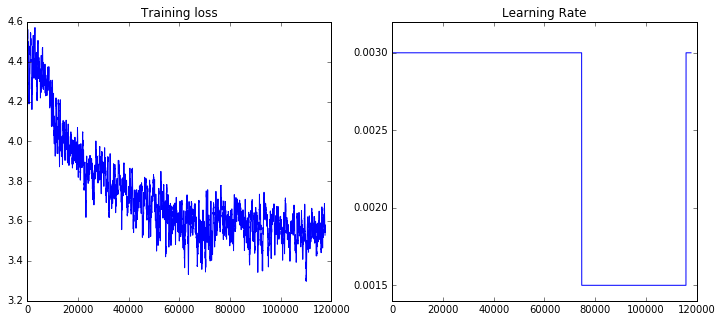

In [6]:
show_val('catenet_adag_flv_slac_2', conn = conn_2, key='top1')
show_val('catenet_adag_flv_slac_2', conn = conn_2, key='top5')
show_train_learnrate('catenet_adag_flv_slac_2', conn = conn_2, do_conv=True, conv_len = 300)

In [299]:
conn_2['whisker_net']['catenet.files'].distinct('exp_id')

[u'catenet_ff_slac',
 u'catenet_adag_ff_slac',
 u'catenet_smmmn_ff_slac',
 u'catenet_smada_ff_slac',
 u'catenet_sm_ff_slac',
 u'catenet_mmnes_ff_slac',
 u'catenet_adag_flv_slac',
 u'catenet_bn_adag_flv',
 u'catenet_bn_adam_flv',
 u'catenet_adag_flv_slac_2',
 u'catenet_bnc_adag_flv',
 u'catenet_bnc_adam_flv',
 u'catenet_bn_flv',
 u'catenet_adagd_flv',
 u'catenet_rms_flv',
 u'catenet_ndrp_adag_flv',
 u'catenet_bnwodrp_adag_flv',
 u'catenet_bnhdrp_adag_flv',
 u'catenet_bnc2_adag_flv',
 u'catenet_adag_flv_slac_3',
 u'catenet_bnc2nfc_adag_flv',
 u'catenet_es_adag',
 u'catenet_bnc2nfc_es_adag',
 u'catenet_deeper',
 u'catenet_larger']

In [249]:
curr_expid = 'catenet_adag_flv_slac_2'
cols = conn_2['whisker_net']['catenet.files'].find({'exp_id': curr_expid, 'saved_filters': True})

In [250]:
cols.count()

23

In [257]:
r_tmp = cols[22]

In [258]:
r_tmp.keys()

[u'saved_filters',
 u'_saver_write_version',
 u'chunkSize',
 u'filename',
 u'_saver_num_data_files',
 u'train_results',
 u'duration',
 u'length',
 u'params',
 u'uploadDate',
 u'step',
 u'exp_id',
 u'_id',
 u'validation_results',
 u'md5']

In [259]:
r_tmp['step']

115000

## Command for training:
python train_catenet.py --gpu 0 --expId catenet_adag_flv_slac_3 --cacheDirPrefix /mnt/fs1/chengxuz --whichopt 2 --initlr 0.003

python train_catenet.py --gpu 0 --expId catenet_adag_flv_slac_3 --cacheDirPrefix /mnt/fs1/chengxuz --whichopt 2 --initlr 0.003 --namefunc catenet_tfutils_old

on node10

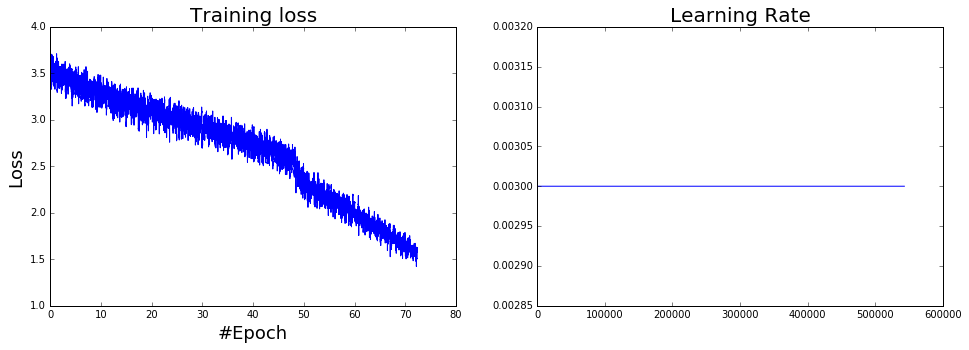

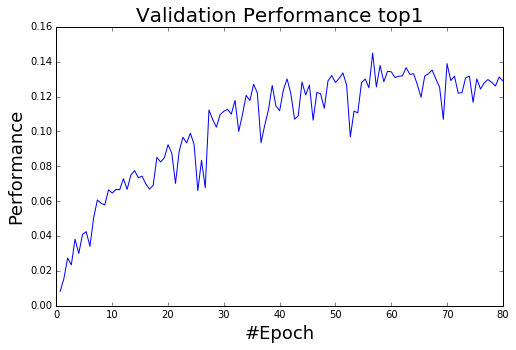

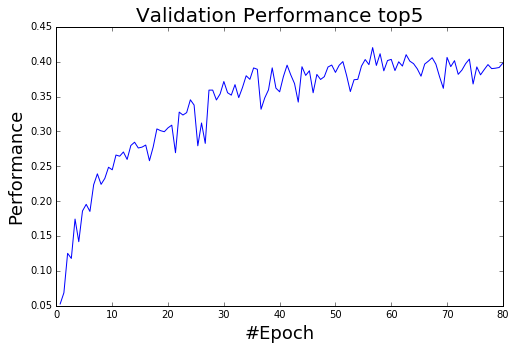

In [98]:
show_train_learnrate('catenet_adag_flv_slac_3', conn = conn_2, do_conv=True, conv_len = 300)
show_val('catenet_adag_flv_slac_3', conn = conn_2, key='top1', do_combine=True)
show_val('catenet_adag_flv_slac_3', conn = conn_2, key='top5', do_combine=True)

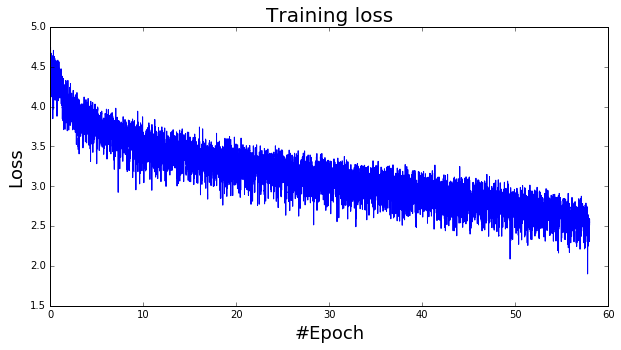

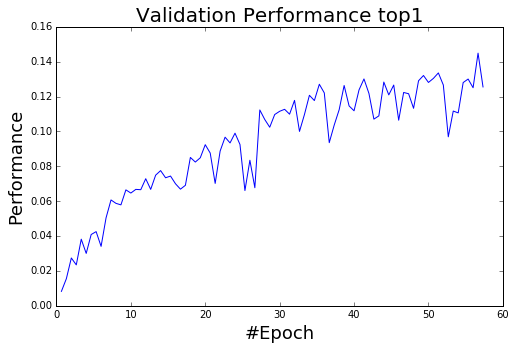

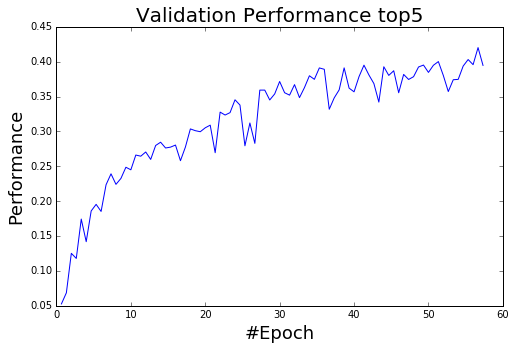

In [78]:
show_train_learnrate('catenet_adag_flv_slac_3', conn = conn_2, do_conv=True, do_combine=True, no_learningrate=True, drop_epoch = 58)
show_val('catenet_adag_flv_slac_3', conn = conn_2, key='top1', do_combine=True, drop_epoch = 58)
show_val('catenet_adag_flv_slac_3', conn = conn_2, key='top5', do_combine=True, drop_epoch = 58)

### Feature extraction

In [793]:
curr_expid = 'catenet_adag_flv_slac_fea_2'

dbname = 'whisker_net'
colname = 'catenet.files'
find_res = conn_2[dbname][colname].find({'exp_id': curr_expid, 'validation_results': {'$exists': True}})

In [794]:
find_res.count()

5

In [767]:
idval = find_res[0]['_id']

In [768]:
coll = conn_2[dbname][colname]
fn = coll.find({'item_for': idval})[0]['filename']

In [773]:
fs = gridfs.GridFS(coll.database, 'catenet')
fh = fs.get_last_version(fn)
saved_data = cPickle.loads(fh.read())
fh.close()

In [776]:
saved_data.keys()

['train_results', 'validation_results']

In [785]:
saved_data['validation_results']['topn']['/cate_root/create_2/fc_add/'][0].shape

(128, 117)

## Network using batch normalization and momentum

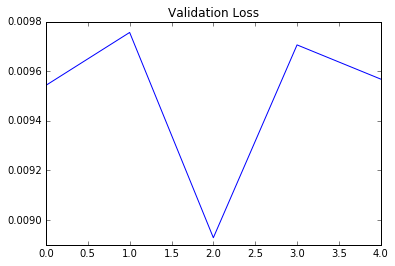

In [226]:
show_val('catenet_bn_flv', conn = conn_2, key='top1')

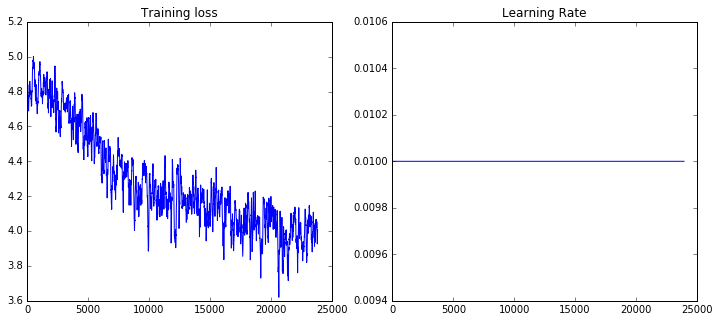

In [227]:
show_train_learnrate('catenet_bn_flv', conn = conn_2, do_conv=True)

## Network without dropout and batch norm, using adagrad, overfitting

python train_catenet.py --gpu 1 --expId catenet_ndrp_adag_flv --cacheDirPrefix /mnt/fs0/chengxuz --whichopt 2 --initlr 0.003 --pathconfig catenet_config_wodrp.cfg

python train_catenet.py --gpu 0 --expId catenet_ndrp_adag_flv --cacheDirPrefix /mnt/fs0/chengxuz --whichopt 2 --initlr 0.003 --pathconfig catenet_config_wodrp.cfg --namefunc catenet_tfutils_old

on node2

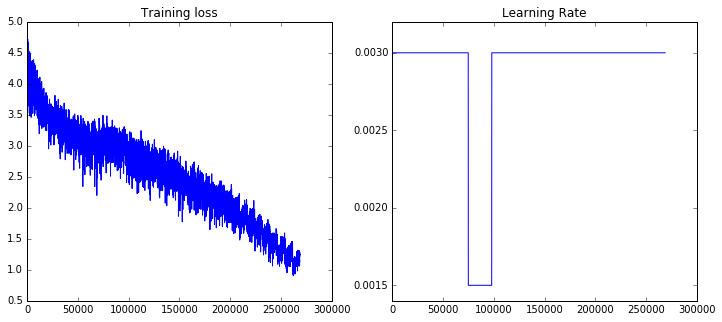

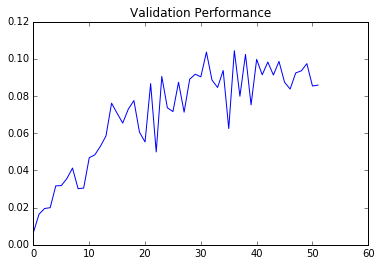

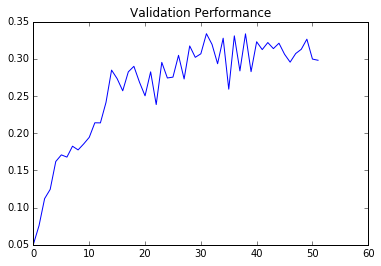

In [718]:
show_train_learnrate('catenet_ndrp_adag_flv', conn = conn_2, do_conv=True)
show_val('catenet_ndrp_adag_flv', conn = conn_2, key='top1')
show_val('catenet_ndrp_adag_flv', conn = conn_2, key='top5')

## Network with batch norm similar in two stages, not faster

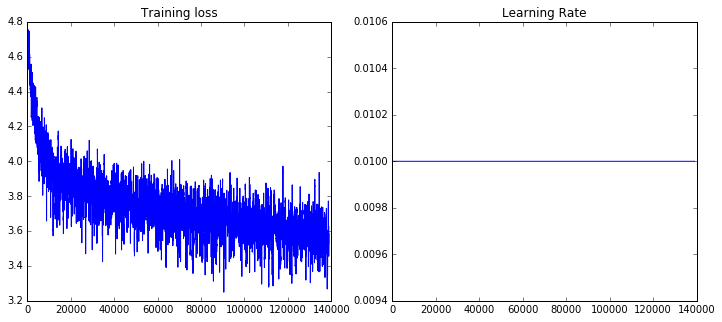

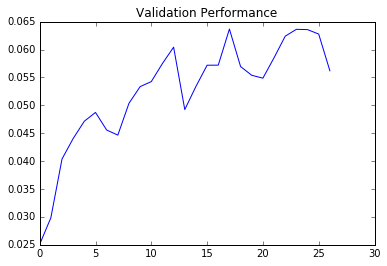

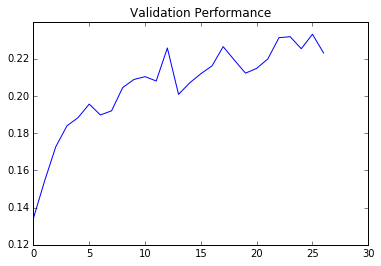

In [550]:
curr_expid = 'catenet_bnc2_adag_flv'
show_train_learnrate(curr_expid, conn = conn_2, do_conv=True)
show_val(curr_expid, conn = conn_2, key='top1')
show_val(curr_expid, conn = conn_2, key='top5')

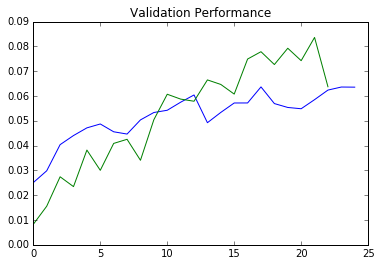

In [520]:
show_val(curr_expid, conn = conn_2, key='top1')
show_val('catenet_adag_flv_slac_2', conn = conn_2, key='top1', new_figure=False)

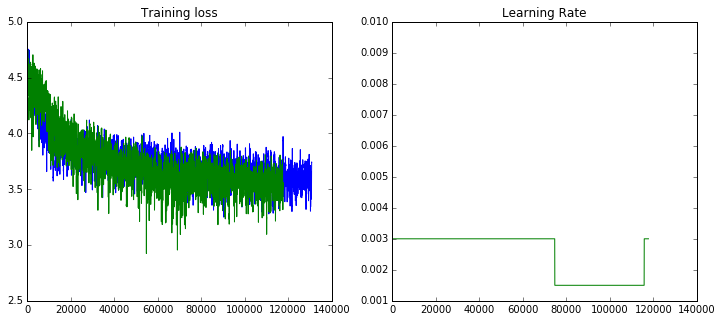

In [521]:
show_train_learnrate(curr_expid, conn = conn_2, do_conv=True)
show_train_learnrate('catenet_adag_flv_slac_2', conn = conn_2, do_conv=True, new_figure=False)

## Network with batch norm similar in two stages, no fc batch norm

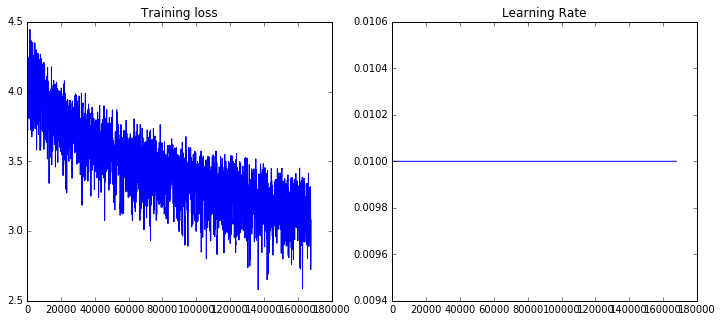

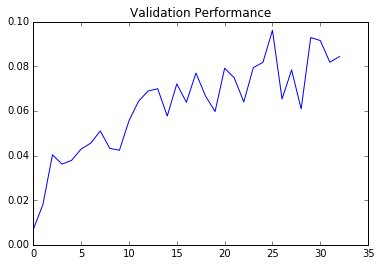

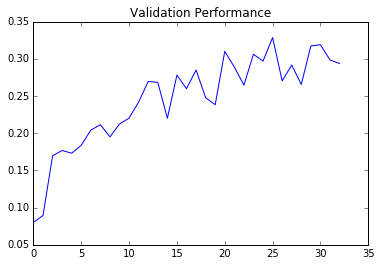

In [610]:
curr_expid = 'catenet_bnc2nfc_adag_flv'
show_train_learnrate(curr_expid, conn = conn_2, do_conv=True)
show_val(curr_expid, conn = conn_2, key='top1')
show_val(curr_expid, conn = conn_2, key='top5')

## Larger network, without bn, using adag

```
{
"BATCH_SIZE": 384,
"QUEUE_CAP": 3840,
"layernum_sub": 7,
"layernum_add": 1,
"dropout": 0.5,
"subnet": {
    "l0": {"conv": {"filter_size1": 9, "filter_size2": 10, "stride": 1, "num_filters": 256},
          "pool": {"filter_size1": 5, "filter_size2": 1, "stride1": 3, "stride2": 1}},
    "l1": {"conv": {"filter_size1": 5, "filter_size2": 10, "stride": 1, "num_filters": 384},
          "pool": {"filter_size": 3, "stride": 2}},
    "l2": {"conv": {"filter_size1": 3, "filter_size2": 5, "stride": 1, "num_filters": 512}},
    "l3": {"conv": {"filter_size1": 3, "filter_size2": 5, "stride": 1, "num_filters": 512}},
    "l4": {"conv": {"filter_size1": 3, "filter_size2": 5, "stride": 1, "num_filters": 256},
          "pool": {"filter_size": 3, "stride": 2}},
    "l5": {"fc": {"num_features": 4096}},
    "l6": {"fc": {"num_features": 1024}}
    },
"addnet": {
    "l0": {"fc": {"num_features": 117}}
    }
}
```
Not working, trying network with smaller filter size

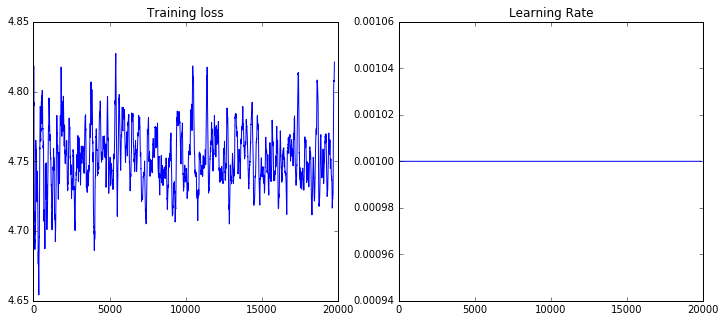

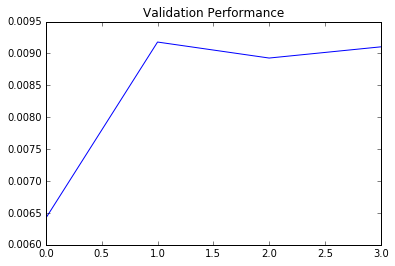

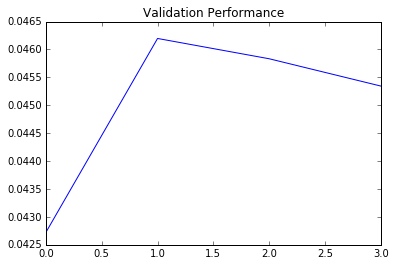

In [357]:
curr_expid = 'catenet_larger'
show_train_learnrate(curr_expid, conn = conn_2, do_conv=True)
show_val(curr_expid, conn = conn_2, key='top1')
show_val(curr_expid, conn = conn_2, key='top5')

### Larger network without modification towards filter size, not working

```
{
"BATCH_SIZE": 384,
"QUEUE_CAP": 3840,
"layernum_sub": 7,
"layernum_add": 1,
"dropout": 0.5,
"subnet": {
    "l0": {"conv": {"filter_size1": 9, "filter_size2": 3, "stride": 1, "num_filters": 128},
          "pool": {"filter_size1": 5, "filter_size2": 1, "stride1": 3, "stride2": 1}},
    "l1": {"conv": {"filter_size1": 5, "filter_size2": 3, "stride": 1, "num_filters": 384},
          "pool": {"filter_size": 3, "stride": 2}},
    "l2": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 512}},
    "l3": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 512}},
    "l4": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 256},
          "pool": {"filter_size": 3, "stride": 2}},
    "l5": {"fc": {"num_features": 4096}},
    "l6": {"fc": {"num_features": 1024}}
    },
"addnet": {
    "l0": {"fc": {"num_features": 117}}
    }
}
```

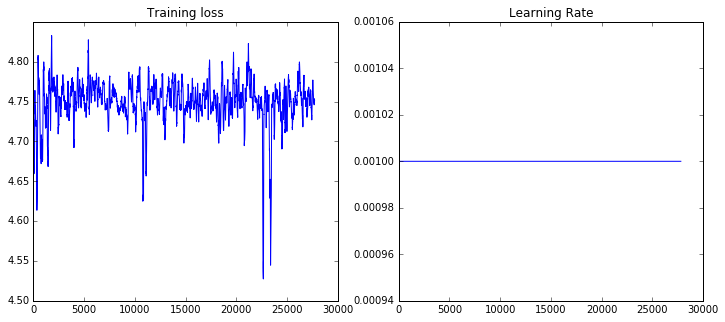

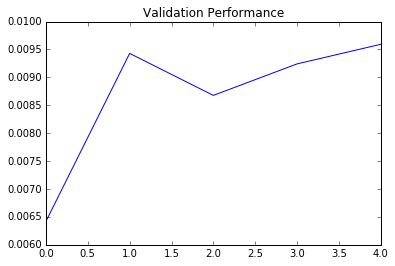

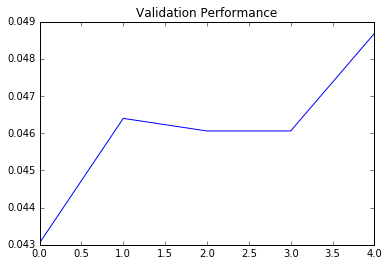

In [501]:
curr_expid = 'catenet_largernf_adag'
show_train_learnrate(curr_expid, conn = conn_2, do_conv=True)
show_val(curr_expid, conn = conn_2, key='top1')
show_val(curr_expid, conn = conn_2, key='top5')

### Larger network without modification towards filter size, only first two layers 

```
{
"BATCH_SIZE": 384,
"QUEUE_CAP": 3840,
"layernum_sub": 7,
"layernum_add": 1,
"dropout": 0.5,
"subnet": {
    "l0": {"conv": {"filter_size1": 9, "filter_size2": 3, "stride": 1, "num_filters": 128},
          "pool": {"filter_size1": 5, "filter_size2": 1, "stride1": 3, "stride2": 1}},
    "l1": {"conv": {"filter_size1": 5, "filter_size2": 3, "stride": 1, "num_filters": 384},
          "pool": {"filter_size": 3, "stride": 2}},
    "l2": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 384}},
    "l3": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 384}},
    "l4": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 256},
          "pool": {"filter_size": 3, "stride": 2}},
    "l5": {"fc": {"num_features": 4096}},
    "l6": {"fc": {"num_features": 1024}}
    },
"addnet": {
    "l0": {"fc": {"num_features": 117}}
    }
}
```

`python train_catenet.py --gpu 0 --expId catenet_largernf1_adag --cacheDirPrefix /mnt/fs0/chengxuz --whichopt 2 --initlr 0.001 --pathconfig catenet_largernf1_config.cfg`

on node8

on node3

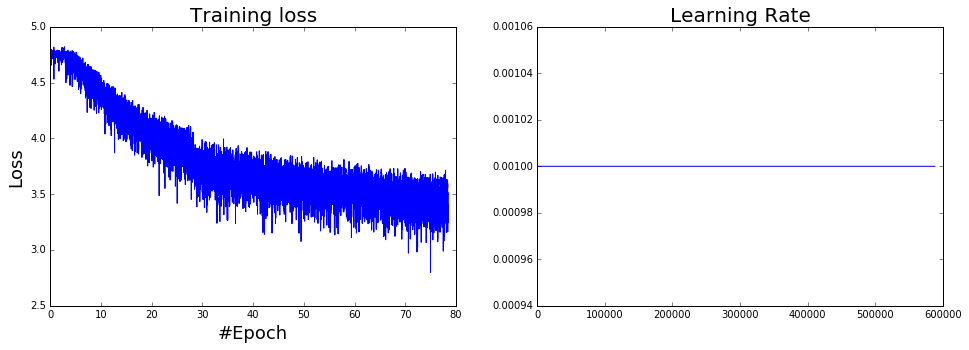

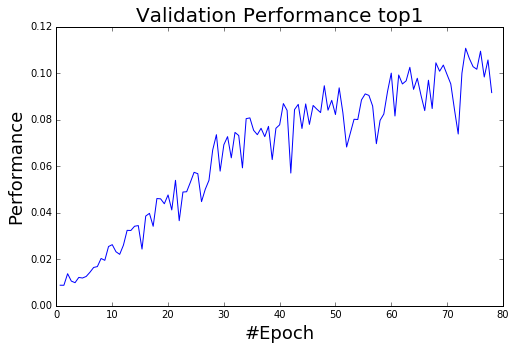

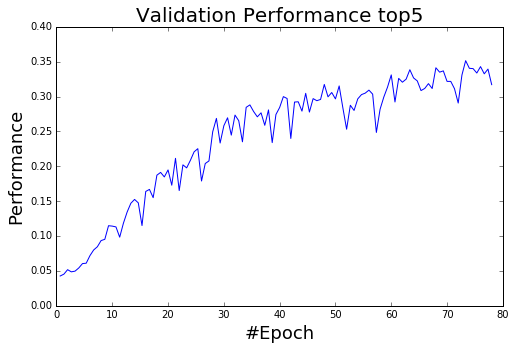

In [99]:
curr_expid = 'catenet_largernf1_adag'
show_status(curr_expid)

### Larger network without modification towards filter size, only conv3 conv4

```
{
"BATCH_SIZE": 384,
"QUEUE_CAP": 3840,
"layernum_sub": 7,
"layernum_add": 1,
"dropout": 0.5,
"subnet": {
    "l0": {"conv": {"filter_size1": 9, "filter_size2": 3, "stride": 1, "num_filters": 96},
          "pool": {"filter_size1": 5, "filter_size2": 1, "stride1": 3, "stride2": 1}},
    "l1": {"conv": {"filter_size1": 5, "filter_size2": 3, "stride": 1, "num_filters": 256},
          "pool": {"filter_size": 3, "stride": 2}},
    "l2": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 512}},
    "l3": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 512}},
    "l4": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 256},
          "pool": {"filter_size": 3, "stride": 2}},
    "l5": {"fc": {"num_features": 4096}},
    "l6": {"fc": {"num_features": 1024}}
    },
"addnet": {
    "l0": {"fc": {"num_features": 117}}
    }
}
```

`python train_catenet.py --gpu 1 --expId catenet_largernf2_adag --cacheDirPrefix /mnt/fs0/chengxuz --whichopt 2 --initlr 0.001 --pathconfig catenet_largernf2_config.cfg`

on node9

on node4

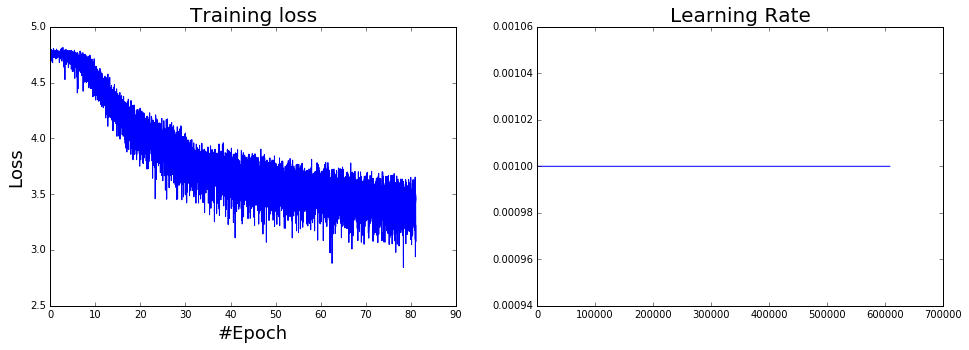

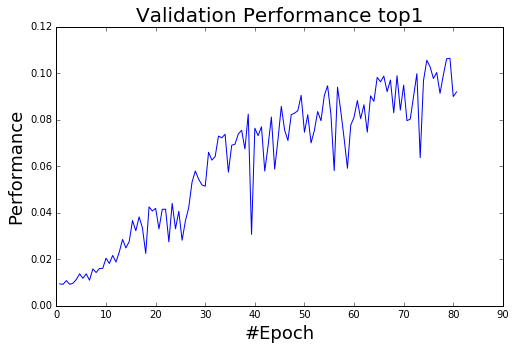

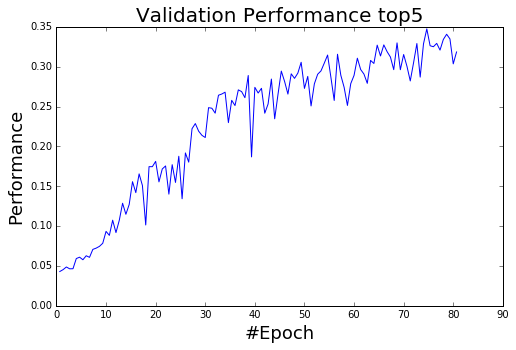

In [100]:
curr_expid = 'catenet_largernf2_adag'
show_status(curr_expid)

## Deeper network, without bn, using adag 

```
{
"BATCH_SIZE": 384,
"QUEUE_CAP": 3840,
"layernum_sub": 11,
"layernum_add": 1,
"subnet": {
    "l0": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 128}},
    "l1": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 128}},
    "l2": {"conv": {"filter_size1": 3, "filter_size2": 3, "stride": 1, "num_filters": 128},
          "pool": {"filter_size1": 3, "filter_size2": 1, "stride1": 3, "stride2": 1}},
    "l3": {"conv": {"filter_size": 3, "stride": 1, "num_filters": 256}},
    "l4": {"conv": {"filter_size": 3, "stride": 1, "num_filters": 256}},
    "l5": {"conv": {"filter_size": 3, "stride": 1, "num_filters": 256},
          "pool": {"filter_size": 3, "stride": 2}},
    "l6": {"conv": {"filter_size": 3, "stride": 1, "num_filters": 384}},
    "l7": {"conv": {"filter_size": 3, "stride": 1, "num_filters": 384}},
    "l8": {"conv": {"filter_size": 3, "stride": 1, "num_filters": 256},
          "pool": {"filter_size": 3, "stride": 2}},
    "l9": {"fc": {"num_features": 4096}},
    "l10": {"fc": {"num_features": 1024}}
    },
"addnet": {
    "l0": {"fc": {"num_features": 117}}
    }
}
```

python train_catenet.py --gpu 0 --expId catenet_deeper --cacheDirPrefix /mnt/fs0/chengxuz --whichopt 2 --initlr 0.003 --pathconfig catenet_deeper_config.cfg --expand 1 --namefunc catenet_tfutils_old

on node5

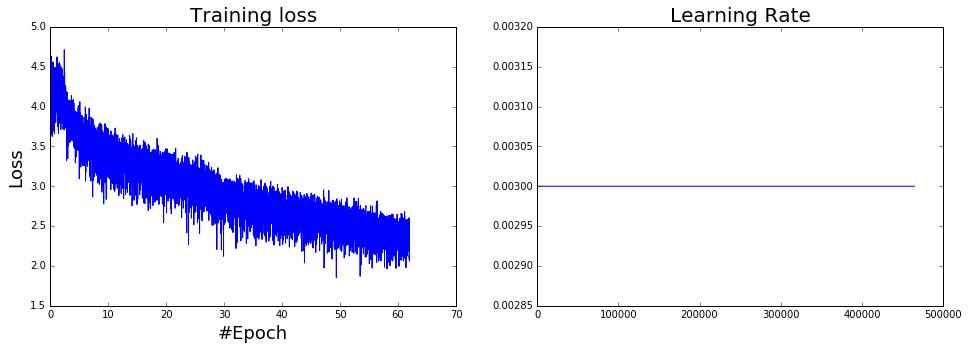

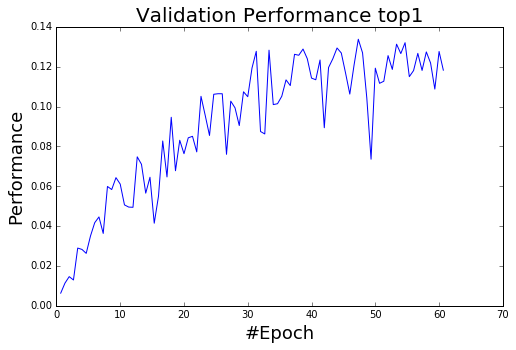

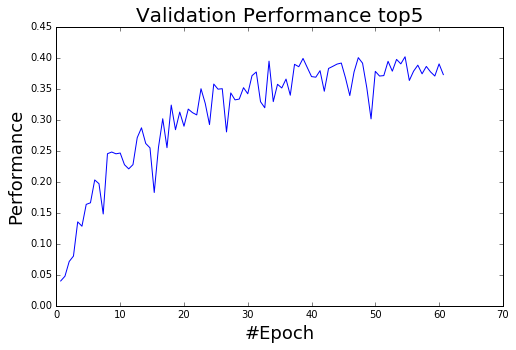

In [101]:
curr_expid = 'catenet_deeper'
show_train_learnrate(curr_expid, conn = conn_2, do_conv=True)
show_val(curr_expid, conn = conn_2, key='top1')
show_val(curr_expid, conn = conn_2, key='top5')

# Network with spatial expansion, no bn, adag, not faster

Use zero vector to fill the spatial emply whiskers

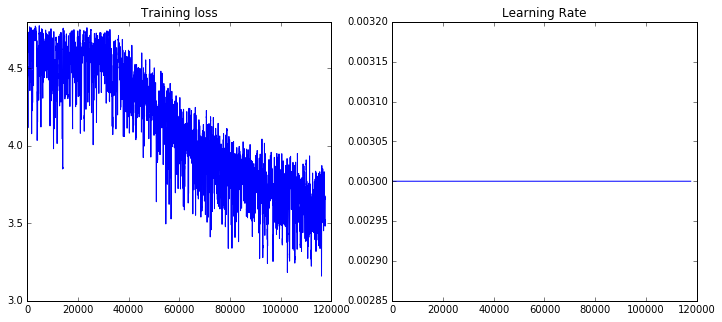

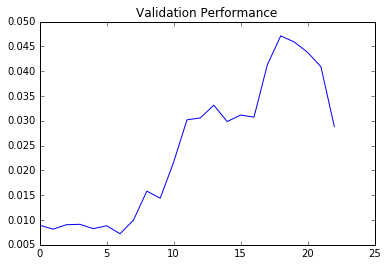

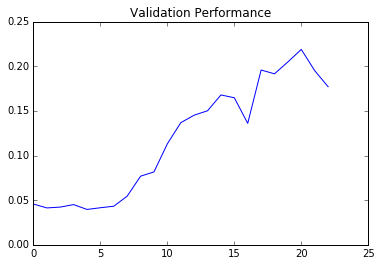

In [572]:
curr_expid = 'catenet_es_adag'
show_train_learnrate(curr_expid, conn = conn_2, do_conv=True)
show_val(curr_expid, conn = conn_2, key='top1')
show_val(curr_expid, conn = conn_2, key='top5')

# Network with spatial expansion, using bn, adag

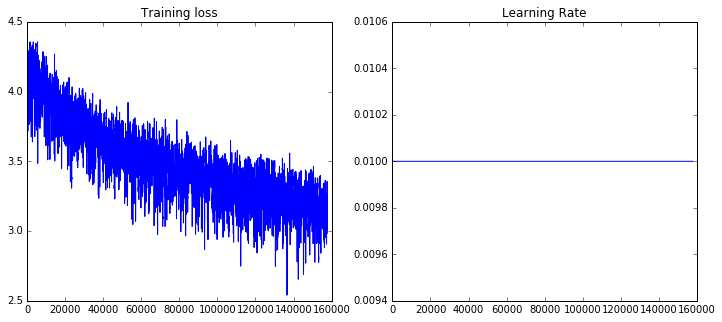

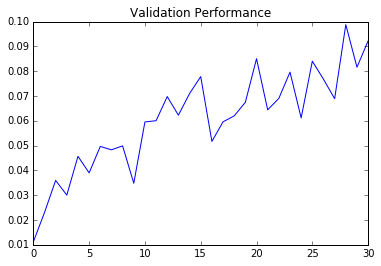

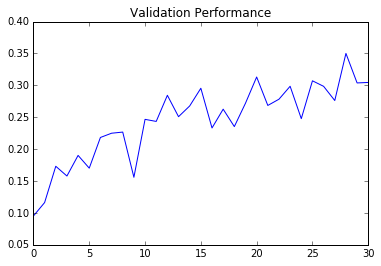

In [659]:
curr_expid = 'catenet_bnc2nfc_es_adag'
show_train_learnrate(curr_expid, conn = conn_2, do_conv=True)
#show_train_learnrate('catenet_adag_flv_slac_2', conn = conn_2, do_conv=True, new_figure=False)
show_val(curr_expid, conn = conn_2, key='top1')
#show_val('catenet_adag_flv_slac_2', conn = conn_2, key='top1', new_figure=False)
show_val(curr_expid, conn = conn_2, key='top5')

## Network with input normalization, using adag, not working

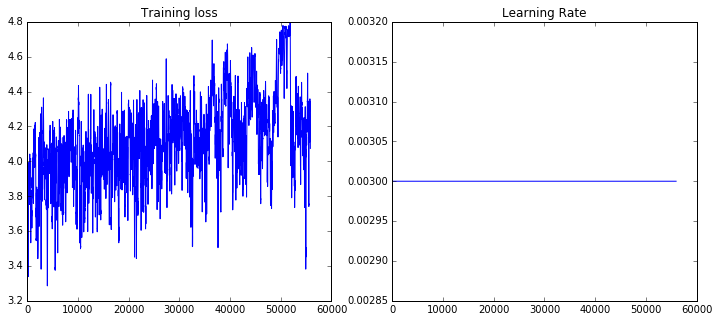

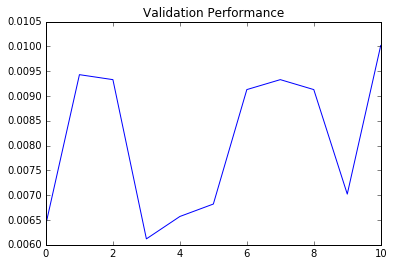

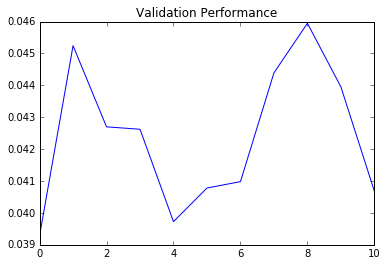

In [565]:
curr_expid = 'catenet_norm_adag'
show_status(curr_expid)

### Using larger learning rate, not working

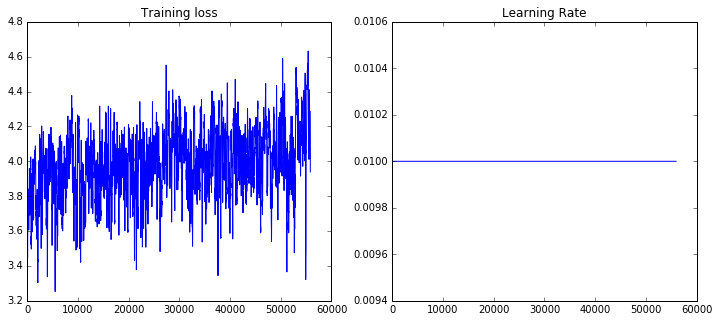

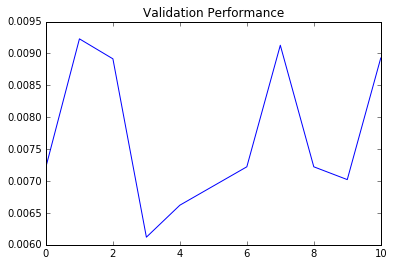

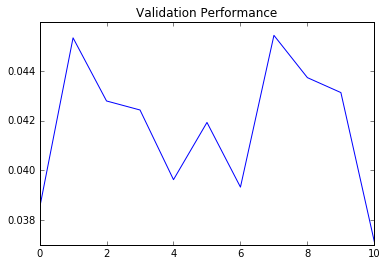

In [564]:
curr_expid = 'catenet_norm_adag_f'
show_status(curr_expid)

## Network with input norm, larger std, using adag

`python train_catenet.py --gpu 0 --expId catenet_normstd_adag --cacheDirPrefix /mnt/fs0/chengxuz --whichopt 2 --initlr 0.003 --norm 1 --norm_std 10000`

on node9

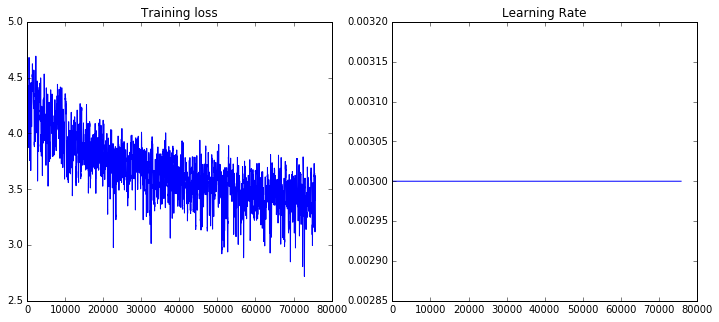

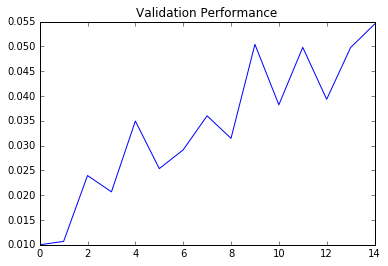

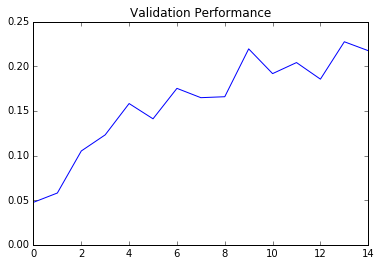

In [602]:
curr_expid = 'catenet_normstd_adag'
show_status(curr_expid)

## Network with input norm, using adam, not working

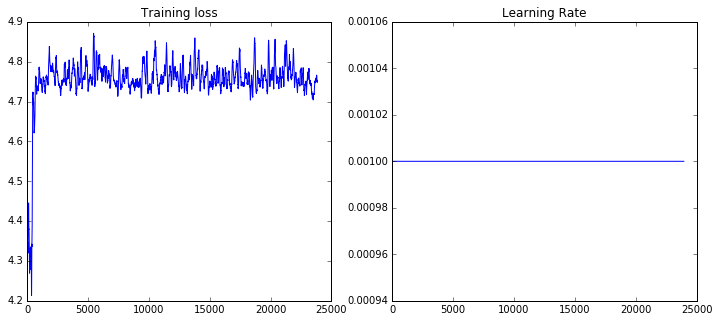

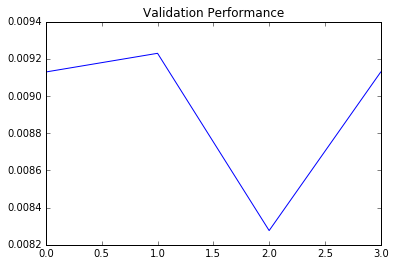

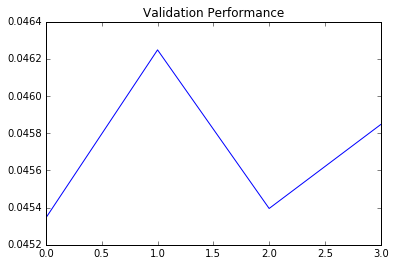

In [479]:
curr_expid = 'catenet_norm_adam_f'
show_status(curr_expid)

## Network with input norm, using momentum, not working

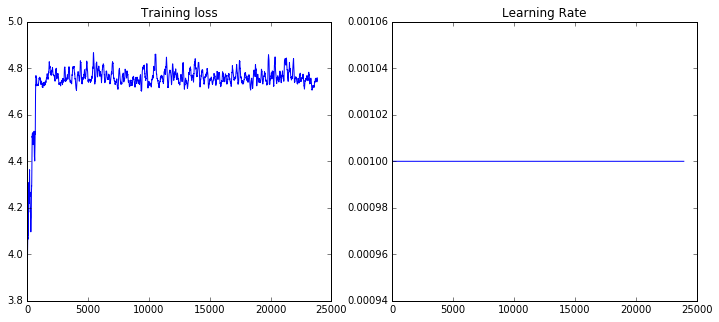

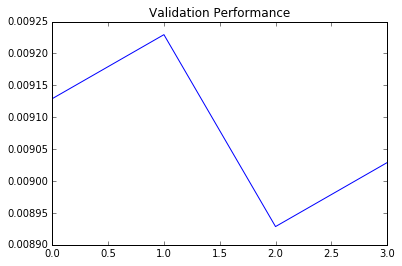

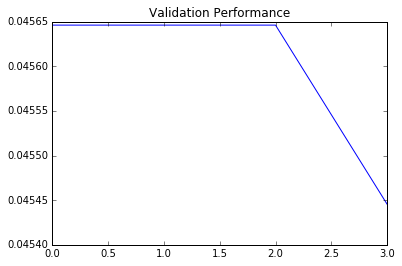

In [480]:
curr_expid = 'catenet_norm_mmt'
show_status(curr_expid)

## Network with 12 swipes, using adag

python train_catenet.py --gpu 0 --expId catenet_12_adag --cacheDirPrefix /mnt/fs0/chengxuz --whichopt 2 --initlr 0.001 --split12 1

on node6

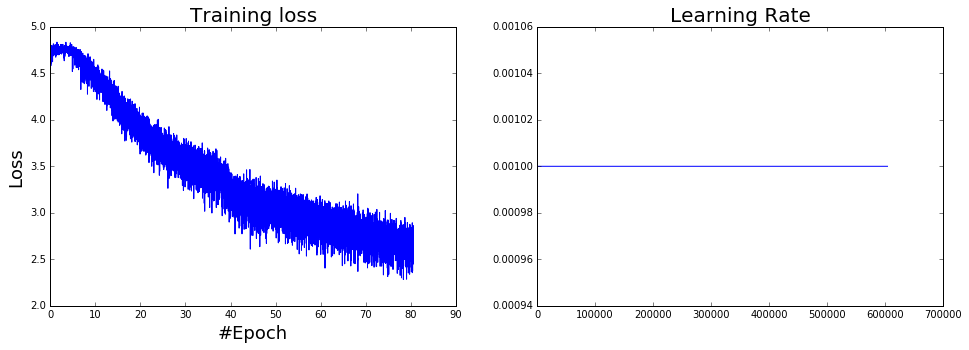

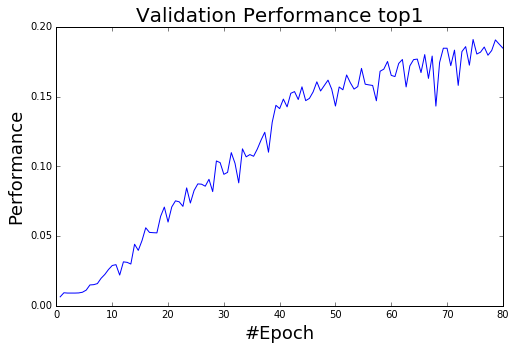

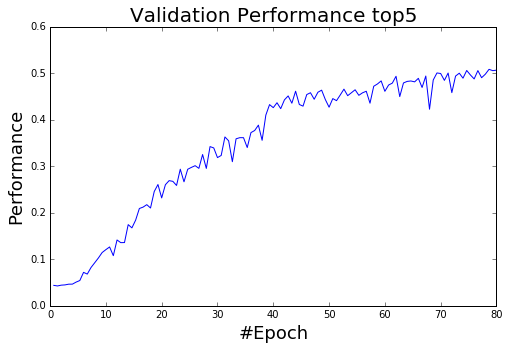

In [102]:
curr_expid = 'catenet_12_adag'
show_status(curr_expid)


## Network changing the filter size, strides

python train_catenet.py --gpu 0 --expId catenet_lstride --cacheDirPrefix /mnt/fs1/chengxuz --whichopt 2 --initlr 0.003 --pathconfig catenet_config_lstride.cfg

on node08

python train_catenet.py --gpu 1 --expId catenet_lstride_larfilt --cacheDirPrefix /mnt/fs1/chengxuz --whichopt 2 --initlr 0.003 --pathconfig catenet_config_lstride_lafs.cfg

on node08

tmux

python train_catenet.py --gpu 0 --expId catenet_lsfilmid --cacheDirPrefix /mnt/fs1/chengxuz --whichopt 2 --initlr 0.003 --pathconfig catenet_config_lsfilmid.cfg

on node9

python train_catenet.py --gpu 1 --expId catenet_larfilmid --cacheDirPrefix /mnt/fs1/chengxuz --whichopt 2 --initlr 0.003 --pathconfig catenet_config_larfilmid.cfg

on node9

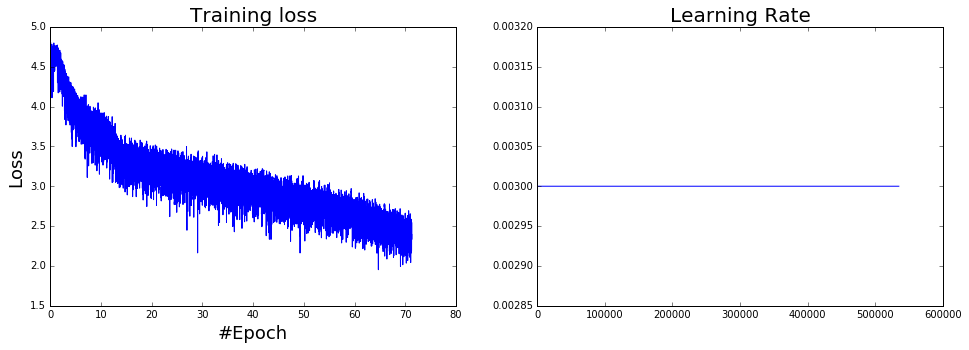

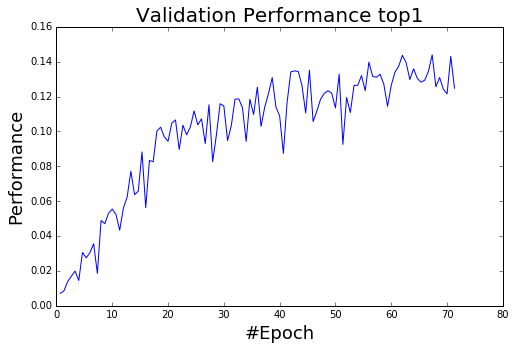

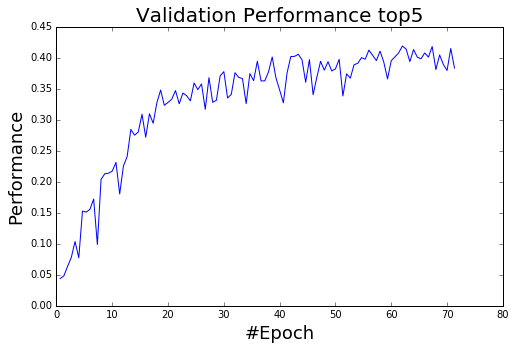

In [103]:
curr_expid = 'catenet_lstride'
show_status(curr_expid)


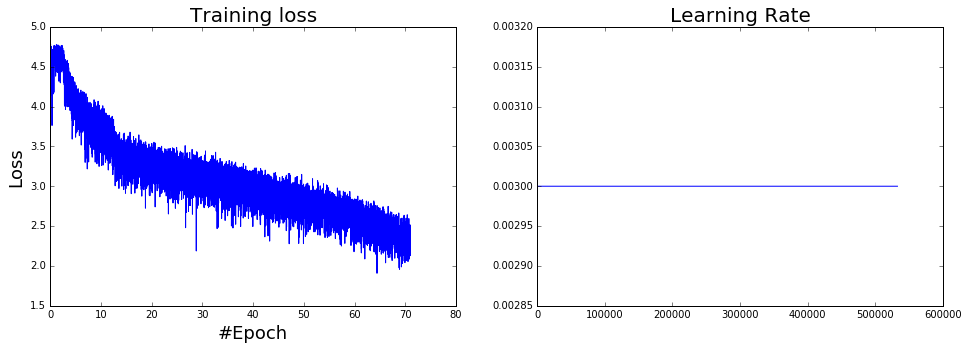

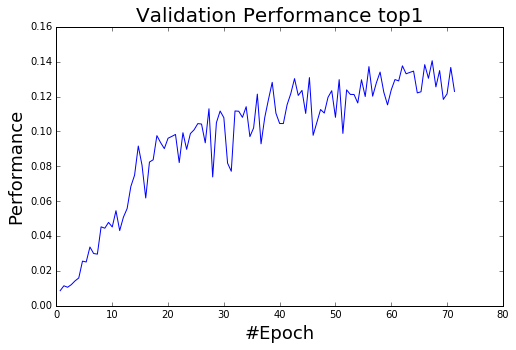

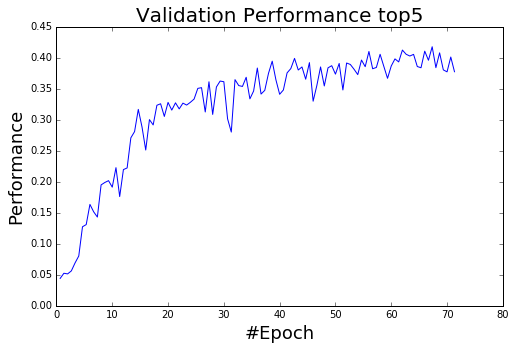

In [104]:
curr_expid = 'catenet_lstride_larfilt'
show_status(curr_expid)
